# Binary Credit Loan Decisions with Unfairness Mitigation

### Task Summary
- Injecting Bias for education purpose
- Historical Context of Credit (not Taiwan Specific)
    - Are there general ethical considerations
- Link reference to EY white paper (replicate workflow)
    - Simulate workflow using synthetic dataset
    - Be transparent about limitations of this approach

## Fairness considerations of credit loan decisions

In this case study, we aim to replicate the work done in collaboration with [*Ernest and Young*](https://www.microsoft.com/en-us/research/uploads/prod/2020/09/Fairlearn-EY_WhitePaper-2020-09-22.pdf) on mitigating gender-related performance disparities in financial lending decisions. Financial service institutions must comply with relevant fair lending laws, such as the *Equal Credit Opportunity Act* in the United States.

## Package Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline
sns.set()

Populating the interactive namespace from numpy and matplotlib


In [2]:
pd.set_option("display.float_format", "{:.3f}".format)

In [3]:
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

In [4]:
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [5]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    count,
    selection_rate,
    demographic_parity_difference,
    demographic_parity_ratio,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate
)

In [6]:
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds

In [7]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [8]:
from datetime import date
import warnings
from pprint import pprint

warnings.simplefilter("ignore")

In [9]:
rand_seed = 1234
np.random.seed(rand_seed)

## Credit Decisions Dataset

Due to data sharing limitations, we will not be able to use the original loans dataset using the *EY* analysis.In this case study, we will be working with a publically available dataset of credit card defaults in Taiwan collected in 2005. This dataset represents binary loan default outcomes for 30,000 applicants with information pertaining to an applicant's 

In [10]:
data = fetch_openml(
    data_id=42477,
    cache=True,
    as_frame=True,
    return_X_y=False
)

In [11]:
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
dataset = (pd.read_excel(io=data_url, header=1)
            .drop(columns=["ID"])
            .rename(columns={"PAY_0": "PAY_1",
                            "default payment next month": "default"})
          )

In [12]:
dataset.shape

(30000, 24)

In [13]:
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [14]:
categorical_features = [
    "SEX",
    "EDUCATION",
    "MARRIAGE"
]

In [15]:
for col_name in categorical_features:
    dataset[col_name] = dataset[col_name].astype("category")

In [16]:
dataset["MARRIAGE"].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [17]:
dataset["EDUCATION"].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [18]:
Y, A = dataset.loc[:, "default"], dataset.loc[:, "SEX"]
X = pd.get_dummies(
    dataset.drop(columns = ["default", "SEX"]))

In [19]:
A_str = A.map({1:"male", 2:"female"})

### Dataset Imbalances

Before we start training a classifier model, we want to explore the dataset for any data distribution imbalances that may 

As part of an exploratory data analysis, let's explore the distribution of our sensitive feature `SEX`. We see most around 60% of loan applicants were labeled as `female` in this dataset.

In [20]:
A_str.value_counts()

female    18112
male      11888
Name: SEX, dtype: int64

In [21]:
A_str.value_counts(normalize=True)

female   0.604
male     0.396
Name: SEX, dtype: float64

Next, let's explore the distribution of the *loan default rate* `Y`. We see that around 78% of individuals in the dataset do not default on their credit loan. While the target label does not display extreme imbalance, we will need to account for this imbalance in our modeling section.

In [22]:
Y.value_counts()

0    23364
1     6636
Name: default, dtype: int64

In [23]:
Y.value_counts(normalize=True)

0   0.779
1   0.221
Name: default, dtype: float64

### Add synthetic noise that is related to the outcome and sex

For the purpose of this tutorial, we add a synthetic feature `Limit` that introduces correlation between the `SEX` label of an applicant and the `default` outcome. The `Limit` feature is drawn from a *Gaussian distribution* with the following criterion:
* If *Male*, draw `LIMIT` from **Normal**(2 $\cdot$ Default, 1)
* If *Female*, draw `LIMIT` from **Normal**(2 $\cdot$ Default, 2)


In [24]:
# If default, Normal(2, 1) for male, Normal(2, 2) for female
# If no default, Normal(0, 1) for male, Normal(0, 2) for female
X.loc[:, "Limit"] = np.random.normal(loc=2*Y, scale=A)

### Check if this will lead to disparity in naive model

Now that we have created our synthetic feature, let's check how this new feature interacts with our *sensitive_feature* `Sex` and our target label `default`. We see that for both sexes, the `LIMIT` feature is higher for individuals who defaulted on their loan.

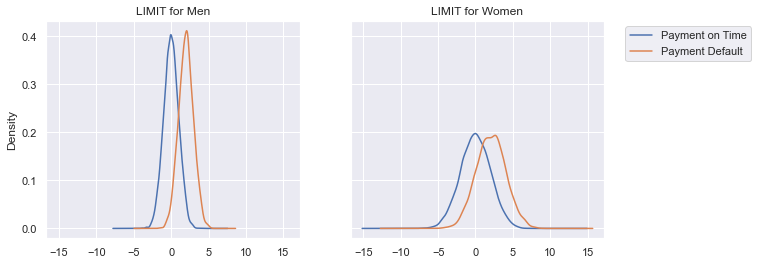

In [25]:
fig, (ax_1, ax_2) = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)
X["Limit"][(A==1) & (Y==0)].plot(kind="kde", label="Payment on Time", ax=ax_1, title="LIMIT for Men")
X["Limit"][(A==1) & (Y==1)].plot(kind="kde", label="Payment Default", ax=ax_1)
X["Limit"][(A==2) & (Y==0)].plot(kind="kde", label="Payment on Time", ax=ax_2, legend=True, title="LIMIT for Women")
X["Limit"][(A==2) & (Y==1)].plot(kind="kde", label="Payment Default", ax=ax_2, legend=True).legend(bbox_to_anchor=(1.6,1))

One thing to note about the `LIMIT` feature we created 

# Training an initial model

In this section, we will train a fairness-unaware model on the training data. However because of the imbalances in the dataset, we will first resample the training data to produce a new balanced training dataset.

In [26]:
def resample_training_data(X_train, Y_train, A_train):
    """
    Method to down-sample the majority class in the training dataset to produce
    a balanced dataset with a 50/50 split in the predictive labels.
    
    Parameters:
    - X_train: The training split of 
    - Y_train: The training split of the target labels
    - A_train: The training split of the sensitive features
    
    Output: 
        Tuple of X_train, Y_train, A_train where each dataset has been re-balanced.
    
    """
    negative_ids = Y_train[Y_train == 0].index
    positive_ids = Y_train[Y_train == 1].index
    balanced_ids = positive_ids.union(np.random.choice(a=negative_ids, size=len(positive_ids)))
    
    X_train = X_train.loc[balanced_ids, :]
    Y_train = Y_train.loc[balanced_ids]
    A_train = A_train.loc[balanced_ids]
    return X_train, Y_train, A_train

In [27]:
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X,
    Y,
    A_str,
    test_size=0.35,
    stratify=Y
)

In [28]:
X_train, y_train, A_train = resample_training_data(X_train, y_train, A_train)

At this stage, we will train a *Gradient-boosted classifier* using the `lightgbm` package on the balanced training dataset. When we evaluate the model, we will use the unbalanced testing dataset.

In [29]:
lgb_params = {
    'objective': 'binary', 
    'metric': 'auc',
    'learning_rate': 0.03,
    "num_leaves": 10,
    "max_depth": 3,
    'random_state': rand_seed
}

In [30]:
estimator = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("classifier", lgb.LGBMClassifier(**lgb_params))
     ])

In [31]:
estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc',
                                num_leaves=10, objective='binary',
                                random_state=1234))])

To get our model's predictions, we compute the *prediction probabilities* for the testing data points. Using the *mean* of the *training labels* as our *prediction threshold*, we predict an applicant will **default** if the *prediction probability* exceeds the *prediction threshold*.

Because we downsampled the *training dataset* to balance the distribution of *positive* and *negative* labels, the *prediction threshold* is equal to `0.5`.

In [32]:
Y_pred_proba = estimator.predict_proba(X_test)[:, 1]
Y_pred = (Y_pred_proba >= np.mean(y_train)) * 1

From the *ROC Score*, we see the model appears to be differentiating between *true positives* and *false positives* well.

In [33]:
roc_auc_score(y_test, Y_pred_proba)

0.8782234705862874

### Feature Importance of the Unmitigated Classifier 

As a model validation check, let's explore the feature importances of our classifier. As expected, our synthetic feature `LIMIT` has the highest feature importance because it is highly correlated with the target variable, by construction.

In [34]:
help(lgb.plot_importance)

Help on function plot_importance in module lightgbm.plotting:

plot_importance(booster, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='Feature importance', ylabel='Features', importance_type='split', max_num_features=None, ignore_zero=True, figsize=None, dpi=None, grid=True, precision=3, **kwargs)
    Plot model's feature importances.
    
    Parameters
    ----------
    booster : Booster or LGBMModel
        Booster or LGBMModel instance which feature importance should be plotted.
    ax : matplotlib.axes.Axes or None, optional (default=None)
        Target axes instance.
        If None, new figure and axes will be created.
    height : float, optional (default=0.2)
        Bar height, passed to ``ax.barh()``.
    xlim : tuple of 2 elements or None, optional (default=None)
        Tuple passed to ``ax.xlim()``.
    ylim : tuple of 2 elements or None, optional (default=None)
        Tuple passed to ``ax.ylim()``.
    title : string or None, optional (

<AxesSubplot:title={'center':'Feature Importance'}, xlabel='Feature importance', ylabel='Features'>

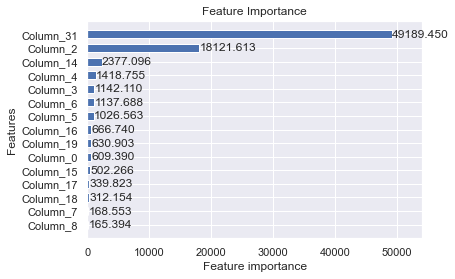

In [35]:
lgb.plot_importance(estimator.named_steps["classifier"], height=0.6, title="Feature Importance", importance_type="gain", max_num_features=15)

# Fairness Assessment of Unmitigated Model

Now that we have trained our initial fairness-unaware model, let's perform our fairness assessment for this model. When conducting a fairness assessment, there are three main steps we want to perform:

1. ) Identify who will be harmed.
2. ) Identify the types of harms we anticipate.
3. ) Define fairness metrics based on the anticipated harms.

## Who will be harmed?

When discussing fairness in AI systems, the first step is understanding what types of harms we anticipate the system may produce. Using the [harms taxonomy in the Fairlearn User Guide](https://fairlearn.org/v0.7.0/user_guide/fairness_in_machine_learning.html#types-of-harms), we expect this system to produce *harms of allocation*. In addition, we also anticipate the long-term impact on an individual's credit score if an individual is unable to repay a loan they receive or if they are rejected for a loan application, depending on where they live.

## Types of harm experienced



A *harm of allocation* occurs when an AI system extends or withholds resources, opportunities, information. In this scenario, the AI system is extending or withholding financial assets from individuals. A review of historical incidents shows these types of automated lending decision systems may discriminate unfairly based on sex.

#### Negative impact of credit score

An auxillary harm that is somewhat unique to credit lending decisions is the long-term impact on an individual's credit score. When applying for a credit loan, there are three major outcomes:

1. The individual receives the credit loan and pays back the loan. In this scenario, we expect the individual's credit score to increase as a result of the successful repayment of the loan.

2. The individual receives the credit loan but defaults on the loan. In this scenario, the individual's credit score will drop drastically due to the failure to repay the loan. In the modeling process, this outcome is tied to a **false positive** (the model predicts the individual will repay the loan, but the individual is unsuccessful in doing so).

3. In certain countries, such as the United States, an individual receives a small drop (up to five points) to their credit score after a lender performs a *hard inquiry* on the applicant's credit history. If the applicant applies for a loan but does not receive it, the small decrease in their credit score will impact their ability to successfully apply for a future loan. In the modeling process, this outcome is tied to the **selection rate** (the proportion of positive predictions outputted by the model).

#### Prevention of wealth accumulation

One other type of harm we anticipate in this scenario is the long-term effects of *denying loans to applicants who would have successfully paid back the loan*. By receiving a loan, an applicant is able to purchase a home, start a business, or pursue some other economic activity that they are not able to do otherwise. These outcomes are tied to **false negative error** rates.

In the United States, the practice of [**redlining**](https://news.trust.org/item/20200713110849-az14m/), denying mortgage loans and other financial services to predominantly Black or other minority communites, has resulted in a vast racial wealth gap between white and Black Americans. Although the practice of redlining was banned in 1968 with the *Fair Housing Act*, the long-term impact of these practices is reflected in the lack of economic investment in Black communities, and Black applicants are denied loans at a higher rate compared to white Americans.

Similarly in many developing nations, women are unfairly rejected from credit and financial institutions, due to being perceived as high-risk by lenders. To combat this discrimination, government and NGOs are developing practices to foster economic inclusitivity for women as part of the *United Nations Sustainable Development Goal 5: Acheive gender equality and empower all women and girls*.

## Define fairness metrics based on harms

Now that we have identified the relevant harms we anticpate users will experience, we can define our fairness metrics.

Based on the above discussion, we will look 

In [36]:
def compute_error_metric(metric_value, sample_size):
    """
    Helper function to compute standard error of a given metric,
    based on assumption of normal distribution.
    
    Parameters - 
        metric_value: Value of the
        sample_size:
    """
    metric_value = metric_value/sample_size
    return 1.96*np.sqrt(metric_value*(1.0-metric_value))/np.sqrt(sample_size)

In [37]:
def false_positive_error(y_true, y_pred):
    """
    Computes the standard error for the false positive rate estimate.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fp, tn+fp)
    
def false_negative_error(y_true, y_pred):
    """
    Computes the standard error for the false negative rate estimate.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return compute_error_metric(fn, fn+tp)

def balanced_accuracy_error(y_true, y_pred):
    """
    Computes the standard error for the balanced accuracy estimate.
    """
    fpr_error, fnr_error = false_positive_error(y_true, y_pred), false_negative_error(y_true, y_pred)
    return np.sqrt(fnr_error**2 + fpr_error**2)/2

In [38]:
fairness_metrics = {
    "count": count,
    "balanced_accuracy": balanced_accuracy_score,
    "balanced_acc_error": balanced_accuracy_error,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "false_positive_error": false_positive_error,
    "false_negative_rate": false_negative_rate,
    "false_negative_error": false_negative_error
}

In [39]:
# Select a subset of metrics to report to avoid information overload
metrics_to_report = [
    "balanced_accuracy",
    "false_positive_rate",
    "false_negative_rate"
]

In [40]:
#Instantiate the MetricFrame for the unmitigated model
metricframe_unmitigated = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=Y_pred,
    sensitive_features=A_test
)

In [41]:
metricframe_unmitigated.by_group[metrics_to_report]

,balanced_accuracy,false_positive_rate,false_negative_rate
SEX,,,
female,0.754,0.256,0.236
male,0.871,0.133,0.124


In [42]:
metricframe_unmitigated.difference()[metrics_to_report]

balanced_accuracy     0.117
false_positive_rate   0.123
false_negative_rate   0.112
dtype: object

In [43]:
metricframe_unmitigated.overall[metrics_to_report]

balanced_accuracy     0.802
false_positive_rate   0.208
false_negative_rate   0.189
dtype: object

In [44]:
def plot_group_metrics_with_error_bars(metricframe, metric, error_name):
  """
  Plots the disaggregated `metric` for each group with an associated
  error bar. Both metric and the erro bar are provided as columns in the 
  provided metricframe.
  """
  grouped_metrics = metricframe.by_group
  point_estimates = grouped_metrics[metric]
  error_bars = grouped_metrics[error_name]
  lower_bounds = point_estimates - error_bars
  upper_bounds = point_estimates + error_bars

  x_axis_names = [str(name) for name in error_bars.index.to_flat_index().tolist()]
  plt.vlines(x_axis_names, lower_bounds, upper_bounds, linestyles="dashed", alpha=0.45)
  plt.scatter(x_axis_names, point_estimates, s=25)
  plt.xticks(rotation=0)
  y_start, y_end = np.round(min(lower_bounds), decimals=2), np.round(max(upper_bounds), decimals=2)
  plt.yticks(np.arange(y_start, y_end, 0.05))
  plt.ylabel(metric)

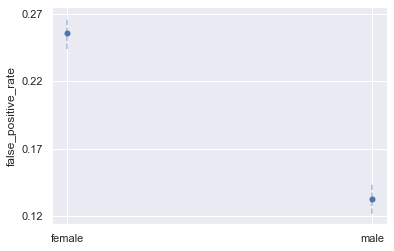

In [45]:
plot_group_metrics_with_error_bars(metricframe_unmitigated, "false_positive_rate", "false_positive_error")

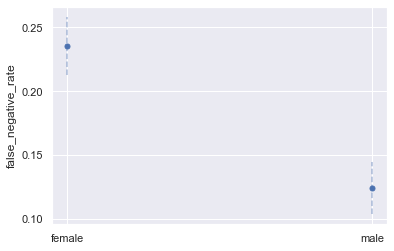

In [46]:
plot_group_metrics_with_error_bars(metricframe_unmitigated, "false_negative_rate", "false_negative_error")

array([[<AxesSubplot:title={'center':'balanced_accuracy'}, xlabel='SEX'>],
       [<AxesSubplot:title={'center':'false_positive_rate'}, xlabel='SEX'>],
       [<AxesSubplot:title={'center':'false_negative_rate'}, xlabel='SEX'>]],
      dtype=object)

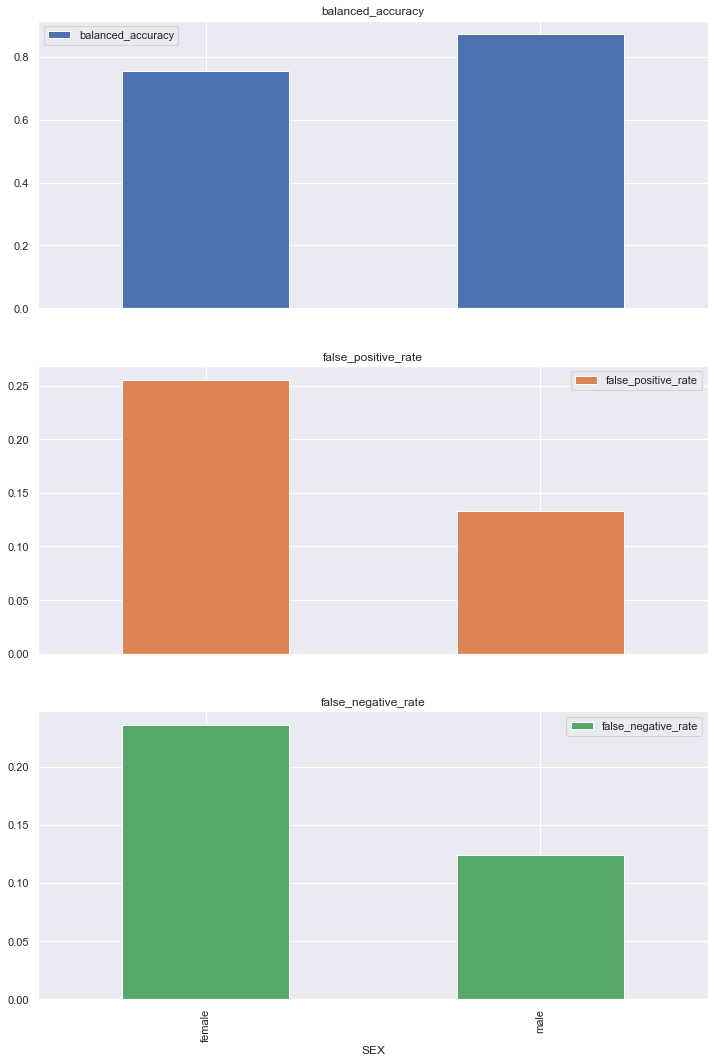

In [47]:
metricframe_unmitigated.by_group[metrics_to_report].plot.bar(subplots=True, layout=[3, 1], figsize=[12,18])

Finally, lets's compute the `equalized_odds_difference` for this unmitigated model. The *equalized_odds_difference* is the maximum of the `false_positive_rate_difference` and `false_negative_rate_difference`. In our lending context, both *false_negative_rate_disparities* and *false_positive_rate_disparities* result in fairness-related harms. Therefore, we aim to  

In [48]:
balanced_accuracy_unmitigated = balanced_accuracy_score(y_test, Y_pred)
equalized_odds_unmitigated = equalized_odds_difference(y_test, Y_pred, sensitive_features=A_test)

# Mitigating Unfairness in ML models

In the previous section, we identified disparities in the model's performance with respect to `SEX`. In particular, we found that model produces a significantly higher `false_negative_rate` and `false_positive_rate` for *females* compared to *males*. In the context of credit decision scenario, this means the model under-allocates loans to *feamles* who would have paid the loan, but over-allocates loans to *females* who go on to default on their loan.

In this section, we will discuss strategies for mitigating the performance disparities we found in our unmitigated model. We will apply two different mitigation strategies:

- *Post-processing*: In the post-processing approach, we will
- *Reductions*:

## Post-processing mitigations: ThresholdOptimizer

To instantiate our `ThresholdOptimizer`, we need to specify our fairness constraint as a model parameter. Because both `false_negative_rate` disparities and `false_positive_rate` disparities translate into real-world harms in our scenario, we will aim to minimize the `equalized_odds` difference as our *fairness constraint*.

In [49]:
postprocess_est = ThresholdOptimizer(
    estimator=estimator,
    constraints="equalized_odds", #Optimize FPR and FNR simultaneously
    prefit=True,
    predict_method="predict_proba"
)

In [50]:
postprocess_est.fit(
    X=X_train,
    y=y_train,
    sensitive_features=A_train
)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=Pipeline(steps=[('preprocessing',
                                              StandardScaler()),
                                             ('classifier',
                                              LGBMClassifier(learning_rate=0.03,
                                                             max_depth=3,
                                                             metric='auc',
                                                             num_leaves=10,
                                                             objective='binary',
                                                             random_state=1234))]),
                   predict_method='predict_proba', prefit=True)

In [51]:
postprocess_pred = postprocess_est.predict(
    X_test,
    sensitive_features=A_test
)

In [52]:
postprocess_pred_proba = postprocess_est._pmf_predict(
    X_test,
    sensitive_features=A_test
)

### Fairness Assessment of post-processing model

In [53]:
def compare_metricframe_results(mframe_1, mframe_2, metrics, names):
    """
    Concatenates the results of two MetricFrames
    """
    return pd.concat(
        [mframe_1.by_group[metrics],
        mframe_2.by_group[metrics]],
        keys=names,
        axis=1
    )

In [54]:
bal_acc_postprocess = balanced_accuracy_score(y_test, postprocess_pred)
eq_odds_postprocess = equalized_odds_difference(y_test, postprocess_pred, sensitive_features=A_test)

In [55]:
metricframe_postprocess = MetricFrame(
    metrics=fairness_metrics,
    y_true=y_test,
    y_pred=postprocess_pred,
    sensitive_features=A_test
)

In [56]:
metricframe_postprocess.overall[metrics_to_report]

balanced_accuracy     0.762
false_positive_rate   0.270
false_negative_rate   0.207
dtype: object

In [57]:
metricframe_postprocess.difference()[metrics_to_report]

balanced_accuracy     0.019
false_positive_rate   0.003
false_negative_rate   0.036
dtype: object

Pull this out for the discussion sections (both the performance drop and access to sensitive features)

In [58]:
compare_metricframe_results(metricframe_unmitigated, metricframe_postprocess, metrics=metrics_to_report, names=["Unmitigated", "PostProcess"])

Unmitigated                                          \
       balanced_accuracy false_positive_rate false_negative_rate   
SEX                                                                
female             0.754               0.256               0.236   
male               0.871               0.133               0.124   

             PostProcess                                          
       balanced_accuracy false_positive_rate false_negative_rate  
SEX                                                               
female             0.753               0.271               0.222  
male               0.773               0.268               0.186

array([[<AxesSubplot:title={'center':'balanced_accuracy'}, xlabel='SEX'>],
       [<AxesSubplot:title={'center':'false_positive_rate'}, xlabel='SEX'>],
       [<AxesSubplot:title={'center':'false_negative_rate'}, xlabel='SEX'>]],
      dtype=object)

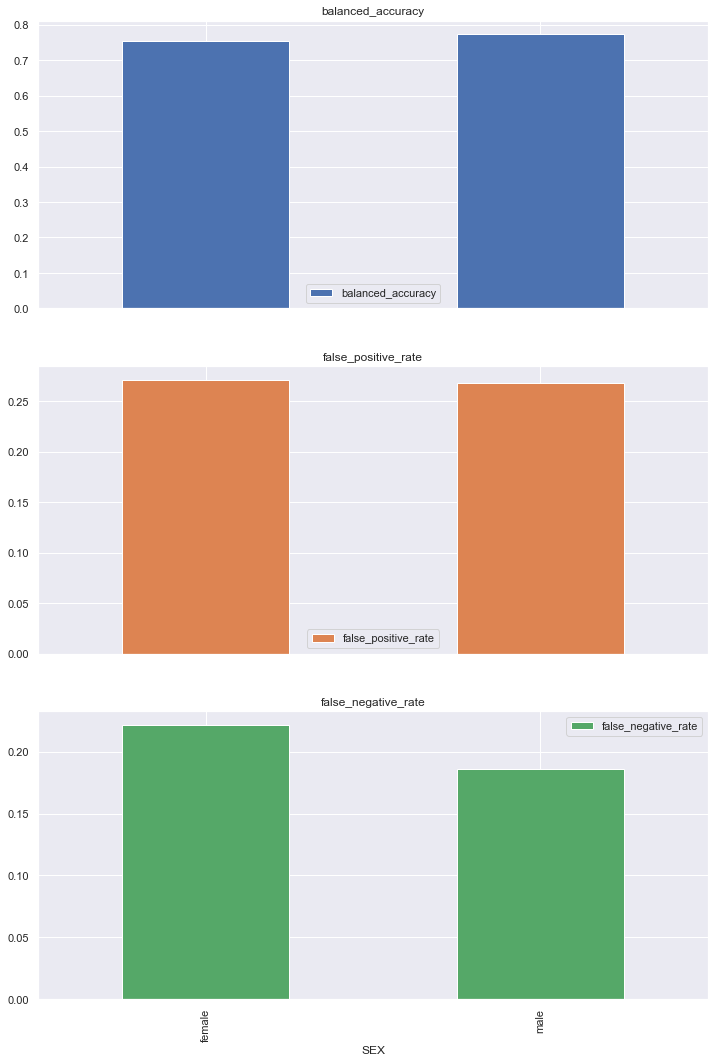

In [59]:
metricframe_postprocess.by_group[metrics_to_report].plot.bar(subplots=True, layout=[3, 1], figsize=[12,18])

Now, let's compute the our *parity metrics* for our `ThresholdOptimizer`.

We see that the `ThresholdOptimizer` algorithm achieves a much lower disparity between 

#### Fairness Under Unawareness

When proving credit models are compliant with fair lending laws, practitoners may run into the issue of not having access to the sensitive demographic features. As a result, financial institutions are often tasked with proving their models are compliant with fair lending laws without having access to the sensitive feature.

For example, under the *Equal Opportunity Credit Act*, financial lenders in the United States must audit credit decision models for racial disparity without having access to an applicant's *race*.

## Reductions Approach to unfairness mitigation

In the previous section, we took a fairness-unaware model and used the `ThresholdOptimizer` to tranform the model's decision boundary to satisfy our fairness constraints. One key limitation of the `ThresholdOptimizer` is needing access to our *sensitive_feature* during prediction time.

In this section, we will use the *reductions* approach from [Agarwal et. al(2018)](https://arxiv.org/pdf/1803.02453.pdf) to produce models that satisify the fairness constraint without needing access to the sensitive features at deployment time.

The main reduction algorithm in Fairlearn is `ExponentiatedGradient`. The algorithm creates a sequence of re-weighted datasets and retrains the wrapped classifier on each of the datasets. This re-training process is guaranteed to find a model that satisfies the fairness constraints while optimizing the performance metric.

The model returned by `ExponentiatedGradient` consists of several inner models, returned by a wrapped estimator.

To instantiate an `ExponentiatedGradient` model, we pass in two parameters:
- a base `estiamtor` (object that supports training)
- fairness `constraints` (object of type `fairlearn.reductions.Moment`)

When passing in a fairness *constaint* as a `Moment`, we can specify an `epsilon` value representing the maximum allowed difference or ratio between our largest and smallest value. For example, in the below code, `EqualizedOdds(difference_bound=epislon)` means that we are using `EqualizedOdds` as our fairness constraint, and we will allow a maximal difference of `epsilon` between our largest and smallest *Equalized Odds* value.

In [60]:
def get_expgrad_models_per_epsilon(estimator, epsilon, X_train, y_train, A_train):
    """
    Instantiate and trains an ExponentiatedGradient model on the
    balanced training dataset.
    
    Parameters:
        - Estimator:
        - Epsilon: Float representing maximum difference bound for the fairness Moment constraint
    
    Returns:
        - Predictors: List of inner model predictors learned by the ExponentiatedModel
        during the training process.
    
    """
    exp_grad_est = ExponentiatedGradient(
        estimator=estimator.named_steps["classifier"],
        constraints=EqualizedOdds(difference_bound=epsilon)
    )
    #Is this an issue - Re-runs
    exp_grad_est.fit(X_train, y_train, sensitive_features=A_train)
    predictors = exp_grad_est.predictors_
    return predictors

Because the *performance-fairness trade-off* learned by the `ExponentiatedGradient` model is sensitive to our chose `epsilon` value, we can treat `epsilon` as a *hyperparameter* and iterate over a range of potential values. Here, we will train two `ExponentiatedGradient` models, one with `epsilon=0.01` and the second with `epsilon=0.02`, and store the inner models learned through each of the training processes.

In [61]:
epsilons = [0.01, 0.02]

In [62]:
all_models = {}
for eps in epsilons:
    all_models[eps] = get_expgrad_models_per_epsilon(estimator=estimator, epsilon=eps,
                                                    X_train=X_train, y_train=y_train, A_train=A_train)

In [63]:
for epsilon, models in all_models.items():
    print(f"For epsilon {epsilon}, ExponentiatedGradient learned {len(models)} inner models")

For epsilon 0.01, ExponentiatedGradient learned 18 inner models
For epsilon 0.02, ExponentiatedGradient learned 19 inner models


Here, we can see all the inner models learned for each value of `epsilon`.

With the `ExponentiatedGradient` model, we specify an `epsilon` parameter that represents the maximal disparity in our fairness metric that we will tolerate

### Select best inner model

In many situations due to regulation or other technical restrictions, the randomized nature of `ExponentiatedGradient` algorithm may be undesirable. In addition, the multiple inner models of the algorithm introduces challenges for model interpretability. One potential workaround to avoiding these issues is selecting one of the inner models and deploying it instead.

In the previous section, we trained multiple `ExponentiatedGradient` models at different `epsilon` levels and collected all the inner models learned by this process. However, some of these inner models are monotonically better performance in both their *balanced error rate* and *equalized odds difference*. We will filter out these *"dominated"* models and plot the performance trade-offs of the remaining models.

In [64]:
def is_pareto_efficient(points):
    """
    Filters a NumPy Matrix to remove rows that are strictly dominated
    by another row in the matrix. Stricly dominated means the all the row values are greater than
    the values of another row.
    
    Parameters:
        Points: NumPy array (NxM) of model metrics. Assumption that smaller values for metrics are preferred.
    
    Returns:
        Boolean Array: Nx1 boolean mask representing the non-dominated indices.
    """
    n, m = points.shape
    is_efficient = np.ones(n, dtype = bool)
    for i, c in enumerate(points):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(points[is_efficient] < c, axis=1)
            is_efficient[i] = True
    return is_efficient

In [65]:
def filter_dominated_rows(points):
    """
    Removes rows from a DataFrame that are monotonically dominated by another
    row in the DataFrame.
    
    Parameters:
        Points:
    
    Returns:
        Pareto_mask: Boolean mask representing indices of input DataFrame that are not monotonically dominated.
        Masked_Dataframe: DataFrame with dominated rows filtered out.
    """
    pareto_mask = is_pareto_efficient(points.to_numpy())
    return pareto_mask, points.loc[pareto_mask, :]
    

In [66]:
def aggregate_predictor_performances(predictors, metric, X_test, Y_test, A_test=None):
    """
    """
    all_predictions = [predictor.predict(X_test) for predictor in predictors]
    if A_test is not None:
        return [metric(Y_test, Y_sweep, sensitive_features=A_test) for Y_sweep in all_predictions]
    else:
        return [metric(Y_test, Y_sweep) for Y_sweep in all_predictions]

In [67]:
def model_performance_sweep(models_dict, X_test, y_test, A_test):
    """
    Computes the equalized_odds_difference and balanced_error_rate for a given list of inner models
    learned by the ExponentiatedGradient algorithm. Returns a DataFrame containing the epsilon level of the model,
    the index of the model, the equalized_odds_difference score and the balanced_error for the model.
    
    Parameters:
    - models_dict:
    - X_test:
    - y_test:
    - A_test: 
    
    Returns:
    
    """
    performances = []
    for (eps, models) in models_dict.items():
        eq_odds_difference = aggregate_predictor_performances(models, equalized_odds_difference, X_test, y_test, A_test)
        bal_acc_score = aggregate_predictor_performances(models, balanced_accuracy_score, X_test, y_test)
        for (i, score) in enumerate(eq_odds_difference):
            performances.append((
                eps,
                i,
                score,
                (1-bal_acc_score[i])
            ))
    performances_df = pd.DataFrame.from_records(performances,
                                               columns=["epsilon", "index", "equalized_odds", "balanced_error"])    
    return performances_df

In [68]:
performance_df = model_performance_sweep(all_models, X_test, y_test, A_test)

In [69]:
performance_subset = performance_df.loc[:, ["equalized_odds", "balanced_error"]]

In [70]:
mask, pareto_subset = filter_dominated_rows(performance_subset)

In [71]:
performance_df_masked = performance_df.loc[mask, :]

Now, let's plot the performance trade-offs between all of our models. 

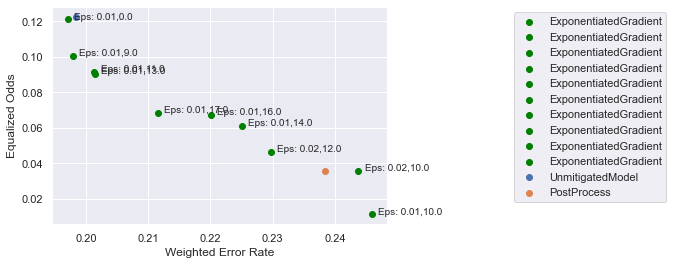

In [72]:
for index, row in performance_df_masked.iterrows():
    bal_error, eq_odds_diff = row["balanced_error"], row["equalized_odds"]
    epsilon_, index_ = row["epsilon"], row["index"]
    plt.scatter(bal_error, eq_odds_diff, color="green", label=f"ExponentiatedGradient")
    plt.text(bal_error+0.001, eq_odds_diff+0.0001, f"Eps: {epsilon_},{index_}", fontsize=10)
plt.scatter(1.0 - balanced_accuracy_unmitigated, equalized_odds_unmitigated,label=f'UnmitigatedModel')
plt.scatter(1.0 - bal_acc_postprocess, eq_odds_postprocess, label=f"PostProcess")
#plt.scatter(1.0 - bal_acc_inprocess, eq_odds_inprocess, label=f"InProcess")
plt.xlabel("Weighted Error Rate")
plt.ylabel("Equalized Odds")
plt.legend(bbox_to_anchor=(1.85,1))

With the above plot, we can see how the performance of the non-dominated inner models compares to the original unmitigated model. In many cases, we see that a reduction in the *equalized_odds_difference* is accompanied by a small increase in the *weighted error rate*.

One strategy we can use to select a model is creating a *threshold* based on the *balanced error rate* of the unmitigated model. Then out of the filtered models, we select the model that minimizes the *equalized_odds_difference*.

Disparity is reduced, but overall performance of model is reduced. What is the correct trade-off?
Amongst all models whose `balanced_error` are below some *threshold*, which is the best model.
- 1.) Create threshold based on balanced_error of the unmitigated model.
- 2.) Filter only models whose balanced_error are below the threshold.
- 3.) Choose the model with smallest equalized_odds difference.

### Performance Plots of ExponentiatedGradient Model

In [73]:
def filter_models_by_unmitigiated_score(all_models, models_frames, unmitigated_score,
                                        performance_metric="balanced_error", fairness_metric="equalized_odds", threshold=0.01):
    """
    Filters out models whose performance score is above the desired threshold.
    Out of the remaining model, return the models with the best score on the fairness metric
    """
    models_filtered = models_frames.query(f"{performance_metric} <= {unmitigated_score + threshold}")
    best_row = models_filtered.sort_values(by=[fairness_metric]).iloc[0]
    epsilon, index = best_row[["epsilon", "index"]]
    return {
        "model": all_models[epsilon][index],
        "epsilon": epsilon,
        "index": index
    }

In [74]:
best_model = filter_models_by_unmitigiated_score(all_models,
                                               models_frames=performance_df,
                                               unmitigated_score=(1.0 - balanced_accuracy_unmitigated))

In [75]:
print(f"Epsilon for best model: {best_model.get('epsilon')}, Index number: {best_model.get('index')}")
inprocess_model = best_model.get("model")

Epsilon for best model: 0.02, Index number: 13.0


In [76]:
y_pred_inprocess = inprocess_model.predict(X_test)

In [77]:
bal_acc_inprocess = balanced_accuracy_score(y_test, y_pred_inprocess)
eq_odds_inprocess = equalized_odds_difference(y_test, y_pred_inprocess, sensitive_features=A_test)

In [78]:
metricframe_inprocess = MetricFrame(
    fairness_metrics,
    y_test,
    y_pred_inprocess,
    sensitive_features=A_test
)

In [79]:
metricframe_inprocess.difference()[metrics_to_report]

balanced_accuracy     0.089
false_positive_rate   0.088
false_negative_rate   0.090
dtype: object

In [80]:
metricframe_inprocess.overall[metrics_to_report]

balanced_accuracy     0.799
false_positive_rate   0.195
false_negative_rate   0.207
dtype: object

array([[<AxesSubplot:title={'center':'balanced_accuracy'}, xlabel='SEX'>],
       [<AxesSubplot:title={'center':'false_positive_rate'}, xlabel='SEX'>],
       [<AxesSubplot:title={'center':'false_negative_rate'}, xlabel='SEX'>]],
      dtype=object)

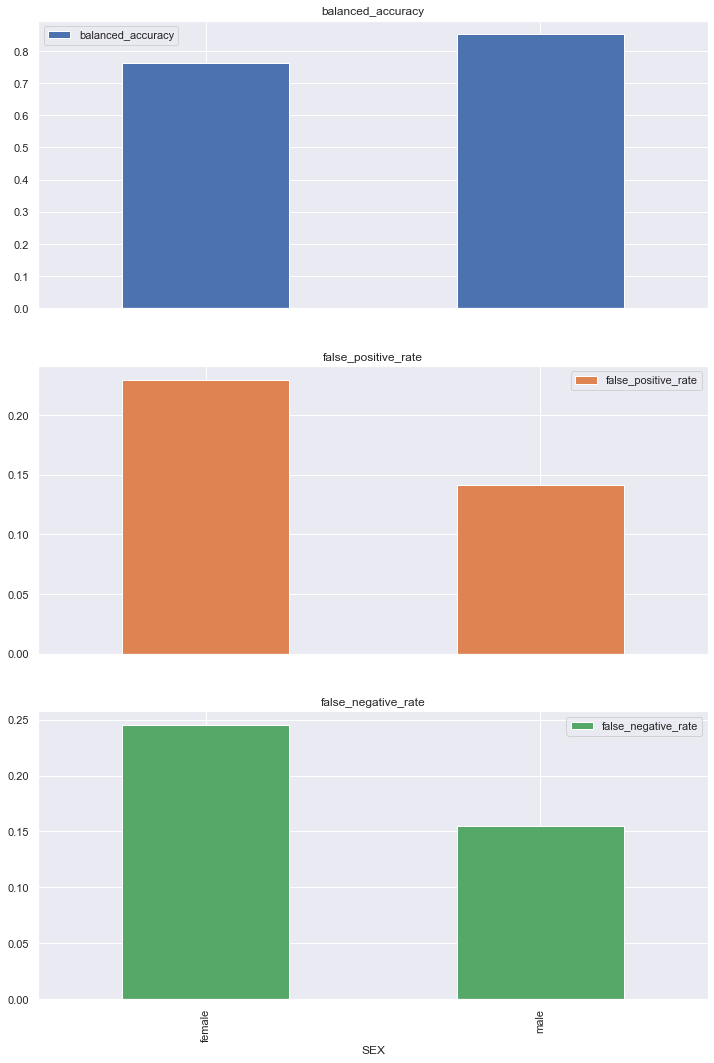

In [81]:
metricframe_inprocess.by_group[metrics_to_report].plot.bar(subplots=True, layout=[3, 1], figsize=[12, 18])

#### Report model performance error bars for metrics

### Discuss Performance and Trade-Offs

In [82]:
metric_error_pairs = [
    ("balanced_accuracy", "balanced_acc_error"),
    ("false_positive_rate", "false_positive_error"),
    ("false_negative_rate", "false_negative_error")
]

In [83]:
def create_metricframe_w_errors(mframe, metrics_to_report, metric_error_pair):
    mframe_by_group = mframe.by_group.copy()
    for (metric_name, error_name) in metric_error_pair:
        mframe_by_group[metric_name] = mframe_by_group[metric_name].apply(lambda x: f'{x:.3f}')
        mframe_by_group[error_name] = mframe_by_group[error_name].apply(lambda x: f'{x:.3f}')
        mframe_by_group[metric_name] = mframe_by_group[metric_name].str.cat(mframe_by_group[error_name], sep="±")
    return mframe_by_group[metrics_to_report]

In [84]:
create_metricframe_w_errors(metricframe_unmitigated, metrics_to_report, metric_error_pairs)

,balanced_accuracy,false_positive_rate,false_negative_rate
SEX,,,
female,0.754±0.013,0.256±0.012,0.236±0.023
male,0.871±0.012,0.133±0.012,0.124±0.021


In [85]:
create_metricframe_w_errors(metricframe_inprocess, metrics_to_report, metric_error_pairs)

,balanced_accuracy,false_positive_rate,false_negative_rate
SEX,,,
female,0.762±0.013,0.230±0.012,0.245±0.023
male,0.852±0.013,0.142±0.012,0.155±0.023


In [86]:
metricframe_unmitigated.overall[metrics_to_report]

balanced_accuracy     0.802
false_positive_rate   0.208
false_negative_rate   0.189
dtype: object

In [87]:
create_metricframe_w_errors(metricframe_postprocess, metrics_to_report, metric_error_pairs)

,balanced_accuracy,false_positive_rate,false_negative_rate
SEX,,,
female,0.753±0.013,0.271±0.012,0.222±0.022
male,0.773±0.014,0.268±0.015,0.186±0.024


In [88]:
metricframe_inprocess.overall[metrics_to_report]

balanced_accuracy     0.799
false_positive_rate   0.195
false_negative_rate   0.207
dtype: object

## Conclusion

In this case study, we walked through the process of assessing a credit decision model for gender-related performance disparities. Our analysis follows closely from the work done in [*Dudik et al.* (2020)](https://www.microsoft.com/en-us/research/uploads/prod/2020/09/Fairlearn-EY_WhitePaper-2020-09-22.pdf). 

### Fairness Mitigation

### Designing a Model Card

A key facet of Responsible Machine Learning is responsible documentation practices. *Mitchell et al. (2019)* proposed the model card framework for documentating and reporting model training details and deployment considerations. 

A *model card* contains sections for documenting 

## Other considerations

### Fairness is not the same as anti-discrimination